# Chemistry machine learning for drug discovery with DeepChem

This example uses machine learning to predict the lipophilicity of compounds.

[Lipophilicity](https://en.wikipedia.org/wiki/Lipophilicity) measures how well a compound dissolves in non-polar media such as fats and lipids. So it's important for drugs that are delivered orally (for example, via a pill) because the active ingredient [needs to be absorbed into the lipids](https://emerypharma.com/blog/drug-lipophilicity-and-absorption-a-continuous-challenge-toward-the-goal-of-drug-discovery/) of biological membranes.

_[Open this notebook in Google Colab]()_

In [1]:
%%capture
%pip install --pre deepchem[tensorflow]

In [2]:
# %%capture
# #For mol_frame
# %pip install git+https://github.com/apahl/mol_frame

# from mol_frame import mol_frame as mf
# import os, holoviews as hv
# os.environ['HV_DOC_HTML'] = 'true'

In [3]:
import deepchem as dc
import seaborn
import pandas as pd
import matplotlib.pyplot as plt

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


[DeepChem](https://deepchem.io/) is a free and open-source Python package for deep learning for chemistry and other sciences. DeepChem has a [lipophilicity data set](https://deepchem.readthedocs.io/en/latest/api_reference/moleculenet.html#lipo-datasets) contains measured [logD](https://www.cambridgemedchemconsulting.com/resources/physiochem/logD.html) values for 4200 compounds. Fitting a machine learning (ML) model to the logarithm of the data values helps reduce the effect of outliers; otherwise, they might skew the model.

As usual for ML, we split the data set into training and test data. We train the ML model on the train data, then apply it to the test data and check how well the model predicts the lipophilicity of compounds that the model hasn't processed before.

For this data set, we [split by scaffold](https://deepchem.readthedocs.io/en/latest/api_reference/splitters.html#scaffoldsplitter) the 4200 compounds based on the [Bemis-Murcko scaffold representation](https://pubs.acs.org/doi/10.1021/jm9602928). Such splitting groups molecules based on their scaffolds (core structure) to [prevent train and test from having very similar molecules](httphttps://github.com/deepchem/deepchem/blob/master/examples/tutorials/Working_With_Splitters.ipynb), which could lead to the model appearing to perform well on the test set, but then performing poorly on less-similar molecules in production.

In [4]:
tasks, datasets, transformers = dc.molnet.load_lipo(featurizer='GraphConv', splitter='Scaffold')
train_dataset, valid_dataset, test_dataset = datasets

The number of compounds in the train, validate, and test sets is:

In [5]:
splits = (train_dataset.X.shape[0], valid_dataset.X.shape[0], test_dataset.X.shape[0])
splits

(3360, 420, 420)

Which represents an 80:10:10 train:validate:test split:

In [6]:
[split / sum(splits) for split in splits]

[0.8, 0.1, 0.1]

Next, we build a model using DeepChem's [graph convolutional network](https://deepchem.readthedocs.io/en/latest/api_reference/models.html). We use the [dropout technique](https://ai-pool.com/a/s/dropout-in-deep-learning) to avoid overfitting.

In [7]:
model = dc.models.GraphConvModel(n_tasks=1, mode='regression', dropout=0.2)

Then we train the model on the train dataset.

Note that training with 200 epochs takes around 8 minutes on Google Colab. If you are debugging or just running a proof of concept, you may want to set nb_epoch=10 to speed execution.

In [8]:
%%capture
model.fit(
    train_dataset, 
    # nb_epoch=200,
    nb_epoch=10,
    )

To check how well the model fits the train and test data, we examine the [Pearson correlation coefficient](https://www.scribbr.com/statistics/pearson-correlation-coefficient/) score, which measures a linear correlation. Its value can range from -1 to 1, where positive values indicate positive correlation, zero indicates no correlation, and negative values indicate negative correlation. The magnitude of the value indicates the strength of the correlation: less than 0.3 is weak, 0.3-0.5 is moderate, and 0.5-1 is strong.

In [9]:
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print("Training set score:", model.evaluate(train_dataset, [metric], transformers))
print("Test set score:", model.evaluate(test_dataset, [metric], transformers))

Training set score: {'pearson_r2_score': 0.4219357130332806}
Test set score: {'pearson_r2_score': 0.24407513456569274}


The [Pearson correlation coefficient](https://www.scribbr.com/statistics/pearson-correlation-coefficient/) score is worse for the test data than for the train data. This is expected because the test data is new to the model. Nevertheless, the magnitude being greater than 0.5 indicates a strong, positive correlation between predicted and measured lipophilicity.

One contributing factor might be that our train set may not have molecules similar enough to those in the test set. Recall that we [split by scaffold](https://deepchem.readthedocs.io/en/latest/api_reference/splitters.html#scaffoldsplitter), so it's possible that such splitting led to compounds in the test set that have scaffolds significantly different from those in the train set.

Adding compounds to the dataset so that there is less "scaffold distance" (difference in scaffold structure) between groups of compounds might help. To take a simple hypothetical example, if we had a dataset with compounds containing fused rings, with many two-ring compounds and few four-ring compounds, scaffold splitting might put all the two-ring compounds in the train set and all the four-ring compounds in the test set. We expect that would lead to poor predictions on the test set. We would want to augment the dataset by adding compounds containing three fused rings.

To learn more about how well the model works, let's apply it to the test data and compare the predicted and experimental results.

In [10]:
lipos = model.predict_on_batch(test_dataset.X)

Then we put the measured and model-predicted results into a [pandas dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) for easy processing.

In [11]:
lipo_list = []
expt_lipo_list = []
for molecule, lipo, test_lipo in zip(test_dataset.ids, lipos, test_dataset.y):
    lipo_list += [lipo[0]]
    expt_lipo_list += [test_lipo[0]]
    
compound_id = list(range(len(test_dataset.ids)))
df = pd.DataFrame(list(zip(expt_lipo_list, lipo_list, test_dataset.ids, compound_id)), columns = ["measured", "predicted", "Smiles", "Compound_Id"])
df

,measured,predicted,Smiles,Compound_Id
0,-1.810832,0.204233,O[C@@H](CNCCCOCCNCCc1cccc(Cl)c1)c2ccc(O)c3NC(=...,0
1,0.319651,0.226531,NC1=NN(CC1)c2cccc(c2)C(F)(F)F,1
2,-0.192325,0.552435,COc1cc(ccc1Cn2ccc3ccc(cc23)C(=O)NCC4CCCC4)C(=O...,2
3,0.938978,0.905381,NC(=O)NC(=O)C(Nc1ccc2CCCc2c1)c3ccccc3,3
4,0.856401,1.033001,COc1ccc(cn1)c2ccc3nc(N)sc3c2,4
...,...,...,...,...
415,0.815112,0.711195,COc1cc(ccc1N2CC[C@@H](O)C2)N3N=Nc4cc(sc4C3=O)c...,415
416,1.327089,0.061670,CCC(COC(=O)c1cc(OC)c(OC)c(OC)c1)(N(C)C)c2ccccc2,416
417,-0.175810,0.378395,CCCSc1ncccc1C(=O)N2CCCC2c3ccncc3,417
418,0.071921,-0.367158,Oc1ncnc2scc(c3ccsc3)c12,418


Now we can use a scatter plot to compare the predicted against measured values, which is called a parity plot. We use the [seaborn statistical data visualization package](https://seaborn.pydata.org/) to plot the data. We show the line where the predicted and measured lipophilicity values are equal, in other words the line that all points would lie on if the model made perfect predictions.

/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


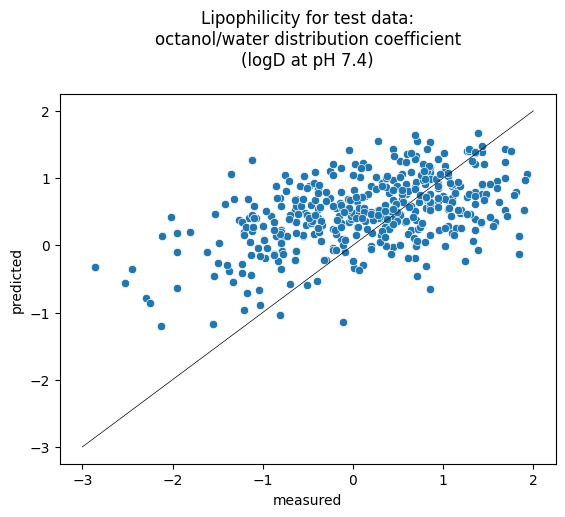

In [12]:
seaborn.scatterplot(data=df, x = "measured", y = "predicted").set(title='Lipophilicity for test data:\noctanol/water distribution coefficient\n(logD at pH 7.4)\n')
equal_line_x = [-3, 2]
equal_line_y = equal_line_x
plt.plot(equal_line_x, equal_line_y, color='k', linewidth=0.5);

We can also use [mol_frame](https://github.com/apahl/mol_frame) to make an interactive plot: If you mouse over a marker on the graph, the molecular structure will be displayed! (One interesting thing to note is that molecules which are close together on the plot may have very different molecular structures.) Also, you can pan and zoom the graph, and save it.

*Unfortunately, the interactive plot is not working in the blog version of this notebook. Please visit the [Google Colab notebook](https://colab.research.google.com/drive/1P7txNo9M6cln-iukWRrLkqFFrZvx7jI3?usp=sharing) to access the interactive plot.*

In [13]:
# cpds = mf.MolFrame(df)
# cpds = cpds.add_b64()
# hv.extension('bokeh')
# cpds.scatter("measured", "predicted")

Let's plot the train data set to visually compare those two sets. We made the markers (points) smaller because there are so many and we don't want them to overlap with each other so much.

/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/var/folders/9w/cn8tqbv976gckxd0c9cbr1sw0000gn/T/ipykernel_84878/3850429294.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  seaborn.scatterplot(data=df_train, x = "measured", y = "predicted", s=5, palette=["orange"]).set(title='Lipophilicity for train data:\noctanol/water distribution coefficient\n(logD at pH 7.4)\n')


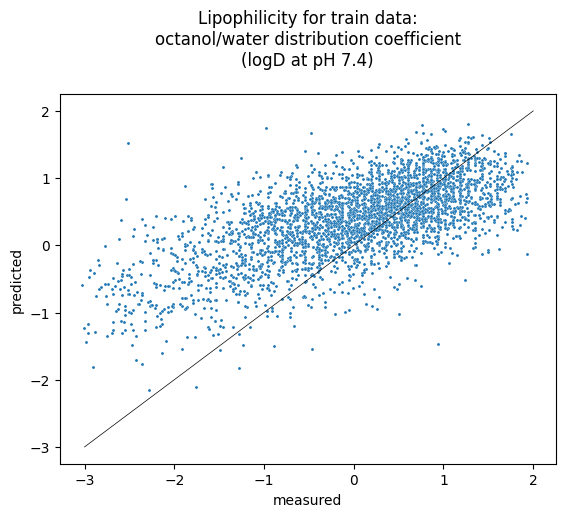

In [14]:
lipos_train = model.predict_on_batch(train_dataset.X)
lipo_list_train = []
expt_lipo_list_train = []
for molecule, lipo, test_lipo in zip(train_dataset.ids, lipos_train, train_dataset.y):
    lipo_list_train += [lipo[0]]
    expt_lipo_list_train += [test_lipo[0]]
df_train = pd.DataFrame(list(zip(expt_lipo_list_train, lipo_list_train)), columns = ["measured", "predicted"])
seaborn.scatterplot(data=df_train, x = "measured", y = "predicted", s=5, palette=["orange"]).set(title='Lipophilicity for train data:\noctanol/water distribution coefficient\n(logD at pH 7.4)\n')
plt.plot(equal_line_x, equal_line_y, color='k', linewidth=0.5);

(Unfortunately, mol_frame takes too long to render thousands of molecules so that Google Colab disconnects before it completes. So we're not showing the interactive plot here. You probably could if you ran this notebook locally.)

To overlay the two plots, we'll first [concatenate the data](https://stackoverflow.com/questions/51732867/seaborn-plot-two-data-sets-on-the-same-scatter-plot#51733133) in the two sets (test and train), adding a `dataset` column to keep track of which set each point came from.

In [15]:
# Remove the columns we added to the test dataframe for mol_frame
try:
  df.drop(columns=["Smiles", "Compound_Id"], inplace=True)
except:
  # Suppress any error if those columns have already been dropped
  pass

concatenated = pd.concat([df.assign(dataset='test'), df_train.assign(dataset='train')])
concatenated

,measured,predicted,dataset
0,-1.810832,0.204233,test
1,0.319651,0.226531,test
2,-0.192325,0.552435,test
3,0.938978,0.905381,test
4,0.856401,1.033001,test
...,...,...,...
3355,0.526093,0.282587,train
3356,-0.027172,0.371371,train
3357,-1.629163,-0.800863,train
3358,0.633443,0.804156,train


Now we can plot the two datasets on one graph.

/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

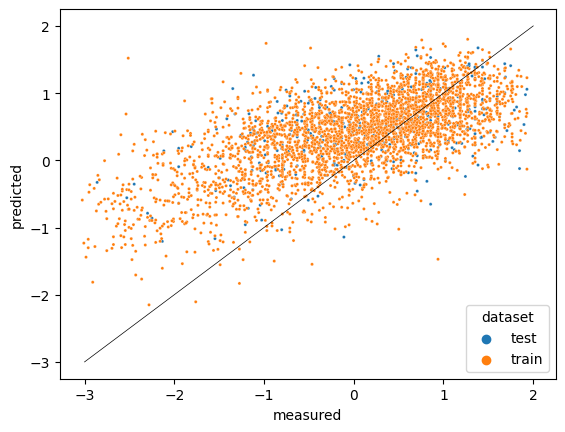

In [16]:
seaborn.scatterplot(x='measured', 
                    y='predicted', 
                    data=concatenated,
                    hue='dataset',
                    s=5)
plt.plot(equal_line_x, equal_line_y, color='k', linewidth=0.5)

Some of the test (blue) data points are predicted (on the vertical axis) outliers, reflecting that the model performs poorly for them. We might consider featurizing our data further to let the model predict lipophilicity based on more properties of the compounds. Above, we used the [`GraphConv`](https://deepchem.readthedocs.io/en/latest/api_reference/featurizers.html#graph-convolution-featurizers) featurizer, which represents only the atoms in a molecule. We might try the [`WeaveFeaturizer`](https://deepchem.readthedocs.io/en/latest/api_reference/featurizers.html#weavefeaturizer) which also represents the bonds, though it requires more resources because it stores the relationship between each pair of atoms in a molecule.

This blog post was based on the DeepChem tutorial [The Basic Tools of the Deep Life Sciences](https://github.com/deepchem/deepchem/blob/master/examples/tutorials/The_Basic_Tools_of_the_Deep_Life_Sciences.ipynb). Thanks to [mol_frame](https://github.com/apahl/mol_frame) author [Axel Pahl](https://github.com/apahl) for making that package usable from Google Colab.

This post was updated on December 28, 2022 to explain the [Pearson correlation coefficient](https://www.scribbr.com/statistics/pearson-correlation-coefficient/) and increase the number of training epochs from 100 to 200.